## Trial-based (epochs-level) decoding in sensor space

In [10]:
from pathlib import Path
import numpy as np

import mne

mne.set_log_level(verbose='WARNING')


subjects = [
    '04', '06', '07','08', '09', '13','14','15','16','18','19',
    '20','21','22','23','24','25','26','27','28','29','30','32'
]

contrast = ['Cond == 1', 'Cond == 3']


N_JOBS = 7


def read_cleaned_epochs(subject):
    # Import epochs
    meg_subject_dir = Path(f'lb_analysis_sparse/import_metadata/sub-{subject}/meg/')
    filename = f'sub-{subject}_task-sparse_metadata_proc-clean_epo.fif'
    epochs_path = meg_subject_dir / filename

    epochs = mne.read_epochs(epochs_path)
    return epochs


def get_epochs_to_contrast(epochs):
    metadata_query = f'{contrast[0]} or {contrast[1]}'
    epochs_to_contrast = epochs[metadata_query]

    # The data was Maxwell-filtered, so gradiometers and magnetometers are
    # correlated and, therefore, practically contain the "same" information.
    # We can therefore use magnetometers only, which will speed up processing
    # as there's only 1/3rd of the number of sensors compared to gradiometers.
    epochs_to_contrast.pick_types(meg='mag')

    return epochs_to_contrast

In [14]:
from pqdm.processes import pqdm

from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression

from mne.decoding import Scaler, Vectorizer


def trial_based_decoding(subject):
    epochs = read_cleaned_epochs(subject)
    epochs_to_contrast = get_epochs_to_contrast(epochs)
    X = epochs_to_contrast.copy().crop(0.05, None).get_data()
    y = epochs_to_contrast.metadata['Cond']

    classification_pipeline = make_pipeline(
        Scaler(
            info=epochs_to_contrast.info,
            scalings='mean'
        ),
        Vectorizer(),  # So we can pass the Scaler() results to scikit-learn
        LogisticRegression(solver='liblinear')
    )

    # Now, actually run the classification, and evaluate it via a cross-validation
    # procedure.
    scores = cross_val_score(
        classification_pipeline,
        X,
        y,
        cv=5,
        n_jobs=N_JOBS
    )
    return scores


subjects = [
    '04', '06', '07','08', # '09', '13','14','15','16','18','19',
    '20','21','22','23','24','25','26','27','28','29','30','32'
]

decoding_scores_all_subjects = pqdm(
    subjects, trial_based_decoding, n_jobs=1
)

  0%|          | 0/16 [00:00<?, ?it/s]

### Looking at decoding performance

In [7]:
print(len(decoding_scores_all_subjects))
print(decoding_scores_all_subjects[3])

4
[0.5        0.46590909 0.43181818 0.4137931  0.51724138]


In [12]:
decoding_scores_all_subjects_mean = np.mean(decoding_scores_all_subjects, axis=1)
decoding_scores_all_subjects_mean

array([0.8424436 , 0.83557842, 0.83115016, 0.84320316])

### Visualizing decoding performance

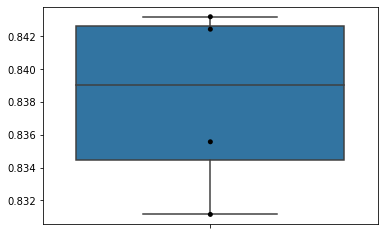

In [13]:
import seaborn as sns

ax = sns.boxplot(y=decoding_scores_all_subjects_mean)
ax = sns.swarmplot(y=decoding_scores_all_subjects_mean, color='black')